# INTRO DMDW Final Project

## Data preparing

### Import and clean data

In [59]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/Users/ponynie/Developer/Python_Code/IntroDMLabChula/Final_Project/Hotel Reservations.csv')
data.drop(['Booking_ID'], axis=1, inplace=True)
data.dropna(inplace=True)
data.head(5)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


### Separeate categorical columns, numerical columns and label

In [60]:
categorical_columns = ['type_of_meal_plan', 
                       'room_type_reserved', 
                       'arrival_year', 
                       'market_segment_type', 
                       'required_car_parking_space']
numerical_columns = ['no_of_adults', 
                     'no_of_children', 
                     'no_of_weekend_nights', 
                     'no_of_week_nights', 
                     'lead_time', 
                     'arrival_month', 
                     'arrival_date', 
                     'repeated_guest', 
                     'no_of_previous_cancellations', 
                     'no_of_previous_bookings_not_canceled', 
                     'avg_price_per_room', 
                     'no_of_special_requests']
label_column = 'booking_status'

for category in categorical_columns:
    data[category] = data[category].astype('category')
data[label_column] = data[label_column].astype('category')

for categorical in categorical_columns:
    print(data[categorical].cat.categories, categorical)
print(data[label_column].cat.categories, "Label")

Index(['Meal Plan 1', 'Meal Plan 2', 'Meal Plan 3', 'Not Selected'], dtype='object') type_of_meal_plan
Index(['Room_Type 1', 'Room_Type 2', 'Room_Type 3', 'Room_Type 4',
       'Room_Type 5', 'Room_Type 6', 'Room_Type 7'],
      dtype='object') room_type_reserved
Index([2017, 2018], dtype='int64') arrival_year
Index(['Aviation', 'Complementary', 'Corporate', 'Offline', 'Online'], dtype='object') market_segment_type
Index([0, 1], dtype='int64') required_car_parking_space
Index(['Canceled', 'Not_Canceled'], dtype='object') Label


### Encode categorical columns to number and convert to Tensor

In [61]:
categorical_np = [data[i].cat.codes.values for i in categorical_columns]
categorical_data = np.stack(categorical_np, 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[0, 0, 0, 3, 0],
        [3, 0, 1, 4, 0],
        [0, 0, 1, 4, 0],
        [0, 0, 1, 4, 0],
        [3, 0, 1, 4, 0],
        [1, 0, 1, 4, 0],
        [0, 0, 0, 4, 0],
        [0, 3, 1, 4, 0],
        [0, 0, 1, 3, 0],
        [0, 3, 1, 4, 0]])

### Convert numerical columns to Tensor

In [62]:
numerical_data = np.stack([data[i].values for i in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:10]

tensor([[  2.0000,   0.0000,   1.0000,   2.0000, 224.0000,  10.0000,   2.0000,
           0.0000,   0.0000,   0.0000,  65.0000,   0.0000],
        [  2.0000,   0.0000,   2.0000,   3.0000,   5.0000,  11.0000,   6.0000,
           0.0000,   0.0000,   0.0000, 106.6800,   1.0000],
        [  1.0000,   0.0000,   2.0000,   1.0000,   1.0000,   2.0000,  28.0000,
           0.0000,   0.0000,   0.0000,  60.0000,   0.0000],
        [  2.0000,   0.0000,   0.0000,   2.0000, 211.0000,   5.0000,  20.0000,
           0.0000,   0.0000,   0.0000, 100.0000,   0.0000],
        [  2.0000,   0.0000,   1.0000,   1.0000,  48.0000,   4.0000,  11.0000,
           0.0000,   0.0000,   0.0000,  94.5000,   0.0000],
        [  2.0000,   0.0000,   0.0000,   2.0000, 346.0000,   9.0000,  13.0000,
           0.0000,   0.0000,   0.0000, 115.0000,   1.0000],
        [  2.0000,   0.0000,   1.0000,   3.0000,  34.0000,  10.0000,  15.0000,
           0.0000,   0.0000,   0.0000, 107.5500,   1.0000],
        [  2.0000,   0.0000

### Convert label to Tensor

In [63]:
outputs = torch.tensor(data[label_column].cat.codes.values).flatten()
outputs[:10]

tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 1], dtype=torch.int8)

### Check correctness of dimension

In [64]:
categorical_data.shape, numerical_data.shape, outputs.shape

(torch.Size([36275, 5]), torch.Size([36275, 12]), torch.Size([36275]))

### Embedding categorical columns for better perfomance

In [65]:
categorical_column_sizes = [len(data[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (7, 4), (2, 1), (5, 3), (2, 1)]


### Separate tran test dataset

In [66]:
total_records = data.shape[0]
test_records = int(total_records * .2) # 20% of the data for testing
train_records = total_records - test_records # 80% of the data for training

categorical_train_data = categorical_data[:train_records]
categorical_test_data = categorical_data[train_records:]
numerical_train_data = numerical_data[:train_records]
numerical_test_data = numerical_data[train_records:]
train_label = outputs[:train_records]
test_label = outputs[train_records:]

print(categorical_train_data.shape, categorical_test_data.shape)
print(numerical_train_data.shape, numerical_test_data.shape)
print(train_label.shape, test_label.shape)

torch.Size([29020, 5]) torch.Size([7255, 5])
torch.Size([29020, 12]) torch.Size([7255, 12])
torch.Size([29020]) torch.Size([7255])


### Define model and network topology

In [67]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x #(batch_size, output_size)

### Adjust hidden layers and instantiate model

In [68]:
hidden_layers = [200,100,50]
class_count = int(data[label_column].cat.codes.nunique())

model = Model(categorical_embedding_sizes, numerical_data.shape[1], class_count, hidden_layers, p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(7, 4)
    (2): Embedding(2, 1)
    (3): Embedding(5, 3)
    (4): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)

### Move all Tensor to MPS backend for GPU training acceleration

In [69]:
if torch.backends.mps.is_available():
    print ("MPS device found.")
else:
    print("MPS device not found.")

mps_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model.to(mps_device)
categorical_train_data = categorical_train_data.to(mps_device)
numerical_train_data = numerical_train_data.to(mps_device)
categorical_test_data = categorical_test_data.to(mps_device)
numerical_test_data = numerical_test_data.to(mps_device)
train_label = train_label.to(mps_device)
test_label = test_label.to(mps_device)  

MPS device found.


### Adjust hyper parameter

In [70]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 150

### The Training loop

epoch:   1 loss: 0.83587968


epoch:  26 loss: 0.52801466
epoch:  51 loss: 0.48576003
epoch:  76 loss: 0.45598876
epoch: 101 loss: 0.43317279
epoch: 126 loss: 0.41805497
epoch: 150 loss: 0.4095604718


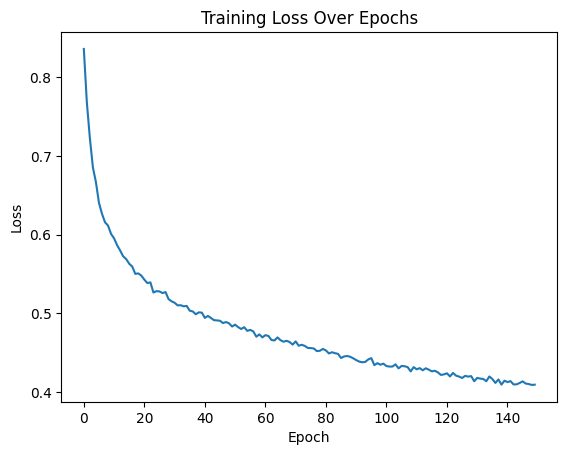

In [71]:
aggregated_losses = []

for i in range(epochs):
    i += 1
    pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(pred, train_label)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

aggregated_losses_on_cpu = [tensor.detach().cpu() for tensor in aggregated_losses]
plt.plot(range(epochs), aggregated_losses_on_cpu)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Model Evaluation 

In [72]:
with torch.no_grad():
    eval = model(categorical_test_data, numerical_test_data)
    loss = loss_function(eval, test_label)
print(f'Loss: {loss:.8f}')


Loss: 0.42691275


In [73]:
print(eval[:5])
eval = np.argmax(eval.detach().cpu(), axis=1)
print(eval[:5])

tensor([[ 0.9034, -1.0582],
        [-1.1600,  0.0412],
        [-0.4998, -0.1000],
        [ 1.8546, -1.5356],
        [-1.4167,  1.9242]], device='mps:0')
tensor([0, 1, 1, 0, 1])


### Report and Confusion Matrix

In [74]:
test_label = test_label.detach().cpu()

print(confusion_matrix(test_label, eval))
print("--------------------------------------------------------------------------------")
print(classification_report(test_label, eval))
print("--------------------------------------------------------------------------------")
print(f"accuracy: {accuracy_score(test_label, eval)*100} %")

[[1457  944]
 [ 491 4363]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      2401
           1       0.82      0.90      0.86      4854

    accuracy                           0.80      7255
   macro avg       0.79      0.75      0.76      7255
weighted avg       0.80      0.80      0.80      7255

--------------------------------------------------------------------------------
accuracy: 80.22053756030324 %
